In [1]:
import numpy as np
import gymnasium as gym

In [2]:
class CarRacingRewardPredictor(gym.Wrapper):
    env = None
    def __init__(self, env):
        super().__init__(env)
        self.env = env
    
    def create_state_dict(self):
        unwrapped_env = self.env.unwrapped

        hull = unwrapped_env.car.hull
        car_state = {
            "pos":    hull.position.copy(),
            "angle":  hull.angle,
            "linvel": hull.linearVelocity.copy(),
            "angvel": hull.angularVelocity,
        }

        wheel_states = []
        for wheel in unwrapped_env.car.wheels:
            wheel_states.append({
                "pos":    wheel.position.copy(),
                "angle":  wheel.angle,
                "linvel": wheel.linearVelocity.copy(),
                "angvel": wheel.angularVelocity,
                "omega":  wheel.omega,
                "phase":  wheel.phase,
                "tiles":  set(wheel.tiles),
            })

        tile_flags = [bool(t.road_visited) for t in unwrapped_env.road]

        general_info = {
            "tile_count":  unwrapped_env.tile_visited_count,
            "cum_reward":  unwrapped_env.reward,
            "prev_reward": unwrapped_env.prev_reward,
            "time":        unwrapped_env.t,
        }

        return {"car": car_state, "wheels": wheel_states, "tiles": tile_flags, "general_info": general_info}

    def restore_state(self, state_dict):
        unwrapped_env = self.env.unwrapped

        hull = unwrapped_env.car.hull
        
        hull.position = state_dict["car"]["pos"]
        hull.angle = state_dict["car"]["angle"]
        hull.linearVelocity = state_dict["car"]["linvel"]
        hull.angularVelocity = state_dict["car"]["angvel"]

        for wheel, wheel_state in zip(unwrapped_env.car.wheels, state_dict["wheels"]):
            wheel.position = wheel_state["pos"]
            wheel.angle = wheel_state["angle"]
            wheel.linearVelocity = wheel_state["linvel"]
            wheel.angularVelocity = wheel_state["angvel"]
            wheel.omega = wheel_state["omega"]
            wheel.phase = wheel_state["phase"]
            wheel.tiles.clear()
            for edge in wheel.contacts:
                other_body = edge.other
                ud = getattr(other_body, 'userData', None)
                if ud and hasattr(ud, 'road_friction'):
                    wheel.tiles.add(ud)
                    

        for tile, tile_flag in zip(unwrapped_env.road, state_dict["tiles"]):
            tile.road_visited = tile_flag

        unwrapped_env.tile_visited_count = state_dict["general_info"]["tile_count"]
        unwrapped_env.reward = state_dict["general_info"]["cum_reward"]
        unwrapped_env.prev_reward = state_dict["general_info"]["prev_reward"]
        unwrapped_env.t = state_dict["general_info"]["time"]
    
    def compute_single_reward(self, action):
        """Compute the reward of the given action

        Args:
            action (np.array): the action to perform

        Returns:
            float, bool, bool: reward, done flag, truncated flag
        """
        state_dict = self.create_state_dict()
        _, reward, done, truncated, _ = self.env.step(action)
        self.restore_state(state_dict)
        return reward, done, truncated
    
    def compute_rewards(self, actions):
        """Given the list of actions, return the associated reward of the given actions

        Args:
            actions (list[np.array]): actions to perform

        Raises:
            Exception: If the types of the actions arguments isn't a List

        Returns:
            List[float]: index i contain the reward of the action at index i in actions
        """
        if type(actions) != list:
            raise Exception(f"Compute reward expect a list of actions but got {actions} instead !")

        rewards = []
        state_dict = self.create_state_dict()
        for action in actions:
            _, reward, _, _, _ = self.env.step(action)
            self.restore_state(state_dict)
            rewards.append(reward)
        
        return rewards

Falled after 266 steps


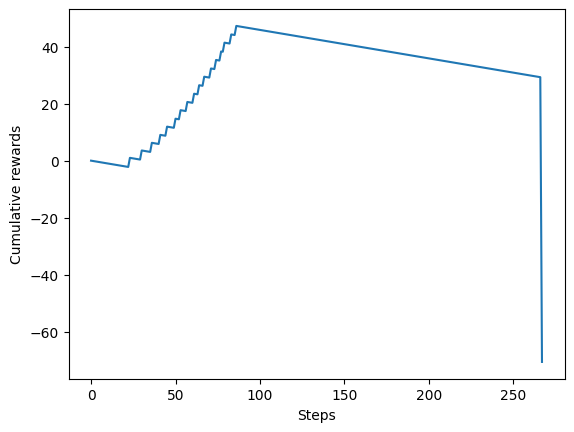

In [3]:
env = CarRacingRewardPredictor(gym.make("CarRacing-v3", render_mode="rgb_array", max_episode_steps = 10500))
obs, _ = env.reset()

# Skip the first second to not have the zooming effect 
for i in range(50):
    env.step(np.array([0,0,0]))

first_reward = None
for i in range (500):
    action = np.array([0.0, 0.8, 0.0])
    r, done, truncated = env.compute_single_reward(action)
    if first_reward != None:
        if r != first_reward:
            raise Exception("Got different rewards where it shoudn't be different")
    else:
        first_reward = r
        
    if done or truncated:
        # This shouldn't appear if the copy is well done
        print(f"Error after {i} steps")
        break

plot = [0]
for i in range (500):
    action = np.array([0.0, 0.8, 0.0])
    _, r, done, trunc, info = env.step(action)
    plot.append(plot[-1] + r)
    
    if i % 10 == 0:
        env.compute_rewards([np.array([0.0, 0.8, 0.0]), np.array([0.0, 0.0, 0.0])])
    if done or trunc:
        print(f"Falled after {i} steps")
        break

env.close()

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(0, len(plot)), plot)
plt.ylabel("Cumulative rewards")
plt.xlabel("Steps")
plt.show()